In [1]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import OverlandFlow, SinkFiller, GroundwaterDupuitPercolator
from landlab.components import CRESTHH, map_gauge_loc_to_node
from landlab.components import CREST, CoupledHydrologicProcess
import matplotlib.pyplot as plt
from landlab.io import read_geotif
from landlab.grid.mappers import map_mean_of_link_nodes_to_link
from osgeo import gdal, ogr
import fiona
import geopandas as gpd
import rasterio

In [2]:
boundaries = {'top': 'closed','bottom': 'open','right':'closed','left':'closed'}
basin= RasterModelGrid((100,160), xy_spacing=10.0, xy_axis_units='-',bc= boundaries)

In [3]:
def construct_topo(x,y):
    #z(500,800)=0
    z= abs(800-x)*0.05+(1000-y)*0.02
    return z
    

In [4]:
dem= np.array([construct_topo(_x,_y) for _y in range(0,1000,10) for _x in range(0,1600,10)]).reshape(basin.shape)
# dem[:80,:50]

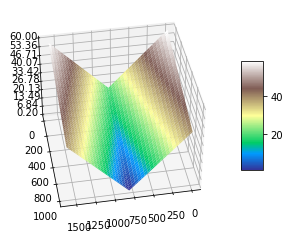

In [5]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0,1600,10)
Y = np.arange(0,1000,10)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = dem

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.terrain,
                       linewidth=0, antialiased=True)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(40, 80)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

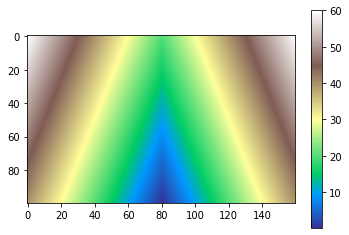

In [6]:
plt.imshow(dem, cmap='terrain')
plt.colorbar()

In [7]:
# define some model parameters
dem= dem.astype(np.float32)
_= basin.add_field('SM0__param', np.zeros_like(dem), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('WM__param', np.ones_like(dem)*0.1, dtype=np.float32, at='node', clobber=True)
channel_manning= np.zeros_like(dem); channel_manning[:,79]= 0.15
riv_width= np.zeros_like(dem); riv_width[:,79]= 20
_= basin.add_field('manning_n__param', np.ones_like(dem)*0.015,
                   dtype=np.float32, at='node', clobber=True)
_= basin.add_field('B__param', np.ones_like(dem), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('KE__param', np.ones_like(dem), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('Ksat_groundwater__param', np.ones(basin.at_link.size,dtype=np.float32)*0.01,
                   dtype=np.float32, at='link', clobber=True)
_= basin.add_field('Ksat_unsaturated__param', np.ones_like(dem)*0.01,
                   dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_width__param', riv_width, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_topo__param', dem.copy(), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_manning__param', channel_manning, dtype=np.float32, at='node', clobber=True)

_= basin.add_field('topographic__elevation', dem, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('aquifer_base__elevation', dem-30, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('aquifer__thickness', np.ones_like(dem)*10, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_width__param', riv_width, dtype=np.float32, at='node', clobber=True)


In [8]:
couple= CoupledHydrologicProcess(basin)
couple.proj= 'EPSG:32215'
couple.precip= np.ones_like(dem)* 100/1000./3600.
couple.evap= np.zeros_like(dem)

In [9]:
zsf= couple.zsf
zgw= couple.zgw
zrv= couple.zrv
sm= couple.SM


In [10]:
def func(y, t, spacing):

    zsf= y[:spacing[0]];sm= y[spacing[0]:spacing[1]];
    zgw= y[spacing[1]:spacing[2]];zrv= y[spacing[2]:]
    f_surf, infil, sm, qsf, qsf_link= couple._surface_flux(zsf, sm, zgw, t)
    print('surface flux:', f_surf, t)
    f_us, recharge= couple._unsaturated_flux(zgw, sm, infil, t)
#     print(recharge, infil)
    print('subsurface flux:',f_us, t)
    f_gw, qgw_to_sf, qgw_to_riv, qgw= couple._ground_water_flux(zsf, zgw, zrv, recharge, t)
    print('groundwater flux:',f_gw, t)
    f_rv, qsf= couple._river_channel_flux(zrv, zsf, zgw, qsf, qsf_link, qgw_to_sf, qgw_to_riv, t)    
    print('river flux:',f_rv, t)
    dydt= np.concatenate([f_surf, f_us, f_gw, f_rv])
#     couple.free_flux()

    
    return dydt

In [11]:
from scipy.integrate import odeint

In [37]:
spacing= np.cumsum([zsf.shape, sm.shape, zgw.shape, zrv.shape])
sol = odeint(func, np.concatenate([zsf, sm, zgw, zrv]),
             [1,60],args=(spacing,), full_output=1)

[ 0.01365838  0.00190941  0.00190941 ...,  0.00983333  0.00983333
  0.00983333]
surface flux: [  2.77777781e-05   1.34376185e-08   1.34376185e-08 ...,   2.77777781e-05
   2.77777781e-05   2.77777781e-05] 1.0
subsurface flux: [ 0.00663026  0.00062084  0.00062084 ...,  0.0042713   0.0042713
  0.0042713 ] 1.0
groundwater flux: [ 0.00396767  0.00117306  0.00117306 ...,  0.00359483  0.00359483
  0.00359483] 1.0
river flux: [  6.11385757e-06   3.30920292e-05   1.19078126e-05   1.18880103e-05
   1.19078294e-05   1.18879710e-05   1.19078504e-05   1.18879728e-05
   1.19078503e-05   1.18879895e-05   1.19078109e-05   1.18880104e-05
   1.19078126e-05   1.18880103e-05   1.19078294e-05   1.18879710e-05
   1.19078504e-05   1.18879728e-05   1.19078504e-05   1.18879886e-05
   1.19078122e-05   1.18880099e-05   1.19078128e-05   1.18880107e-05
   1.19078208e-05   1.18880008e-05   1.19078408e-05   1.18879802e-05
   1.19078389e-05   1.18880008e-05   1.19078407e-05   1.18880008e-05
   1.19078201e-05   1.1887

In [38]:
zsf= sol[0][-1][:spacing[0]];sm= sol[0][-1][spacing[0]:spacing[1]];
zgw= sol[0][-1][spacing[1]:spacing[2]];zrv= sol[0][-1][spacing[2]:]

<ipython-input-39-d089b2b0f6f2>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
<ipython-input-39-d089b2b0f6f2>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
<ipython-input-39-d089b2b0f6f2>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same 

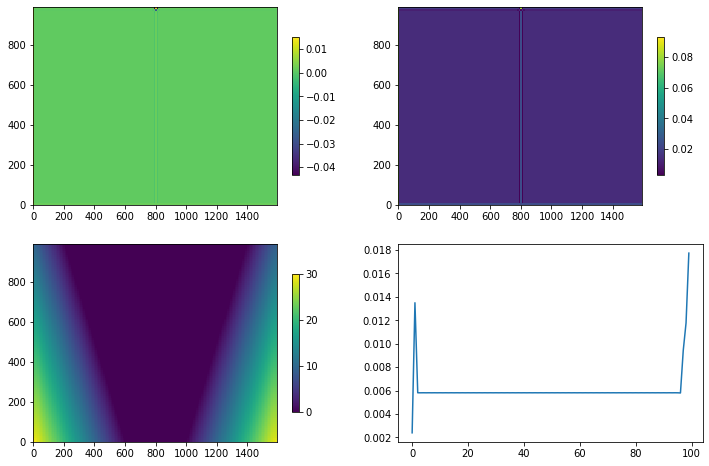

In [39]:
fig=plt.figure(figsize=(12,8))
ax= fig.add_subplot(221)
cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   (zsf-couple.zsf_base).reshape(couple.shape), )
plt.colorbar(mappable=cs, shrink=0.7)
ax= fig.add_subplot(222)
cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   sm.reshape(couple.shape), )
plt.colorbar(mappable=cs, shrink=0.7)
ax= fig.add_subplot(223)
cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   (zgw-couple.zgw_base).reshape(couple.shape), )
plt.colorbar(mappable=cs, shrink=0.7);
ax= fig.add_subplot(224)
ax.plot(zrv-couple.zrv_btm[couple._river_cores]);

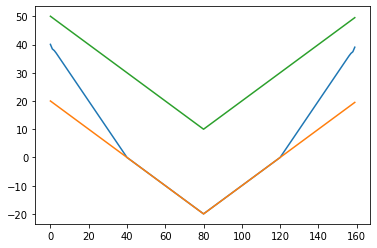

In [40]:
plt.plot(zgw.reshape(basin.shape)[50,])
plt.plot(couple.zgw_base.reshape(basin.shape)[50,])
plt.plot(zsf.reshape(basin.shape)[50,])

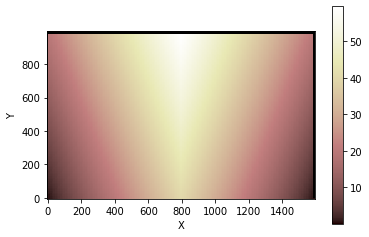

In [21]:
imshow_grid(basin, zsf-couple.zgw)

In [77]:
basin.links_at_node[couple._river_cores]* basin.link_dirs_at_node

ValueError: operands could not be broadcast together with shapes (100,4) (16000,4) 

In [74]:
basin.map_sum_of_outlinks_to_node?

Signature: basin.map_sum_of_outlinks_to_node(var_name, out=None)
Docstring:
Map the sum of links leaving a node to the node.

map_sum_of_outlinks_to_node takes an array *at the links* and finds the
outlink values for each node in the grid. it sums the outlinks and returns
values at the nodes.

.. note::

    This considers all inactive links to have a value of 0.

Parameters
----------
var_name : array or field name
    Values defined at links.
out : ndarray, optional
    Buffer to place mapped values into or `None` to create a new array.

Returns
-------
ndarray
    Mapped values at nodes.

Examples
--------
>>> import numpy as np
>>> from landlab.grid.raster_mappers import map_sum_of_outlinks_to_node
>>> from landlab import RasterModelGrid

>>> rmg = RasterModelGrid((3, 4))
>>> _ = rmg.add_field("z", np.arange(17.), at="link")
>>> map_sum_of_outlinks_to_node(rmg, 'z')
array([  3.,  5.,  7.,   6.,  17.,  19.,  21.,  13.,  14.,  15.,  16.,
         0.])

LLCATS: NINF LINF MAP
File:    

In [67]:
couple._flow_dir.flow__link_to_receiver_node()[couple._river_cores[2]]

AttributeError: 'FlowDirectorSteepest' object has no attribute 'flow__link_to_receiver_node'

In [35]:
dir(couple._flow_dir)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active_links',
 '_activelink_head',
 '_activelink_tail',
 '_bc_set_code',
 '_changed_surface',
 '_check_updated_bc',
 '_cite_as',
 '_current_time',
 '_determine_link_directions',
 '_flow_link_direction',
 '_grid',
 '_info',
 '_is_Voroni',
 '_is_raster',
 '_links_to_receiver',
 '_method',
 '_name',
 '_receiver',
 '_steepest_slope',
 '_surface',
 '_surface_values',
 '_to_n_receivers',
 '_unit_agnostic',
 'cite_as',
 'coords',
 'current_time',
 'definitions',
 'direct_flow',
 'downstream_node_at_link',
 'flow_link_direction',
 'flow_link_direction_at_node',
 'flow_link_incoming_at_node',
 'from_path',
 'grid',
 'initialize

In [32]:
couple.zrv_btm[couple._river_cores]

array([ 20.5,  20.3,  20.1,  19.9,  19.7,  19.5,  19.3,  19.1,  18.9,
        18.7,  18.5,  18.3,  18.1,  17.9,  17.7,  17.5,  17.3,  17.1,
        16.9,  16.7,  16.5,  16.3,  16.1,  15.9,  15.7,  15.5,  15.3,
        15.1,  14.9,  14.7,  14.5,  14.3,  14.1,  13.9,  13.7,  13.5,
        13.3,  13.1,  12.9,  12.7,  12.5,  12.3,  12.1,  11.9,  11.7,
        11.5,  11.3,  11.1,  10.9,  10.7,  10.5,  10.3,  10.1,   9.9,
         9.7,   9.5,   9.3,   9.1,   8.9,   8.7,   8.5,   8.3,   8.1,
         7.9,   7.7,   7.5,   7.3,   7.1,   6.9,   6.7,   6.5,   6.3,
         6.1,   5.9,   5.7,   5.5,   5.3,   5.1,   4.9,   4.7,   4.5,
         4.3,   4.1,   3.9,   3.7,   3.5,   3.3,   3.1,   2.9,   2.7,
         2.5,   2.3,   2.1,   1.9,   1.7,   1.5,   1.3,   1.1,   0.9,   0.7], dtype=float32)

In [27]:
sol

(array([[ 60.        ,  59.5       ,  59.        , ...,   1.10000002,
           0.89999998,   0.69999999],
        [ 60.        ,  59.5       ,  59.        , ...,   1.10000002,
           0.89999998,   0.69999999]]),
 {'hu': array([ 0.]),
  'tcur': array([ 1.]),
  'tolsf': array([ 0.]),
  'tsw': array([ 1.]),
  'nst': array([0], dtype=int32),
  'nfe': array([31], dtype=int32),
  'nje': array([0], dtype=int32),
  'nqu': array([0], dtype=int32),
  'imxer': 48100,
  'lenrw': 769620,
  'leniw': 48120,
  'mused': array([0], dtype=int32),
  'message': 'Repeated convergence failures (perhaps bad Jacobian or tolerances).'})

In [150]:
output= sol[0]

In [153]:
spacing[0]

16000

In [154]:
output.shape

(60, 48100)

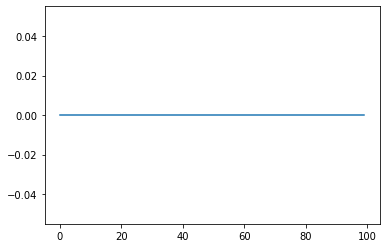

In [157]:
plt.plot(output[10,spacing[2]:])


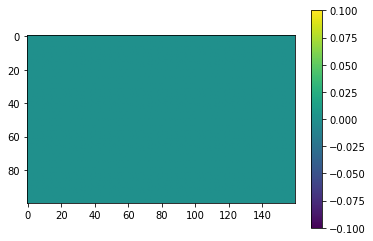

In [155]:
plt.imshow(output[10,spacing[2]:].reshape(couple.shape))
plt.colorbar()

In [ ]:
dir(basin)

In [63]:
from landlab.components.flow_director import FlowDirectorSteepest

In [33]:
zriv_grid= np.zeros_like(couple.zsf)
zriv_grid[couple._river_cores]= zrv

In [34]:
zriv_grid

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [66]:
dir(FlowDirectorSteepest)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_changed_surface',
 '_check_updated_bc',
 '_cite_as',
 '_determine_link_directions',
 '_info',
 '_name',
 '_unit_agnostic',
 'cite_as',
 'coords',
 'current_time',
 'definitions',
 'direct_flow',
 'downstream_node_at_link',
 'flow_link_direction',
 'flow_link_direction_at_node',
 'flow_link_incoming_at_node',
 'from_path',
 'grid',
 'initialize_optional_output_fields',
 'initialize_output_fields',
 'input_var_names',
 'link_to_flow_receiving_node',
 'links_to_receiver',
 'name',
 'node_receiving_flow',
 'node_steepest_slope',
 'optional_var_names',
 'output_var_names',
 'run_one_step',
 'shape',
 'sink_flag',
 'surface_v

In [37]:
boundaries = {'top': 'closed','bottom': 'open','right':'closed','left':'closed'}
new_field= RasterModelGrid((100,160), xy_spacing=10.0, xy_axis_units='-',bc= boundaries)
new_field.add_field('topographic__elevation', zriv_grid)
fd= FlowDirectorSteepest(new_field)
# fd.grid['topographic__elevation'][:]= zriv_grid

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [44]:
fd.run_one_step()

In [63]:
dir(fd)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active_links',
 '_activelink_head',
 '_activelink_tail',
 '_bc_set_code',
 '_changed_surface',
 '_check_updated_bc',
 '_cite_as',
 '_current_time',
 '_determine_link_directions',
 '_flow_link_direction',
 '_grid',
 '_info',
 '_is_Voroni',
 '_is_raster',
 '_links_to_receiver',
 '_method',
 '_name',
 '_receiver',
 '_steepest_slope',
 '_surface',
 '_surface_values',
 '_to_n_receivers',
 '_unit_agnostic',
 'cite_as',
 'coords',
 'current_time',
 'definitions',
 'direct_flow',
 'downstream_node_at_link',
 'flow_link_direction',
 'flow_link_direction_at_node',
 'flow_link_incoming_at_node',
 'from_path',
 'grid',
 'initialize

In [73]:
fd.node_receiving_flow[couple._river_cores[5]]

878

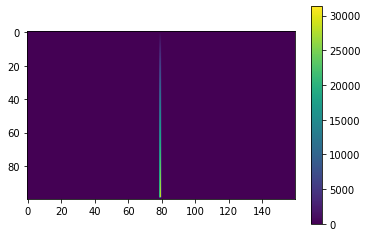

In [81]:
plt.imshow(fd.links_to_receiver.reshape(couple.shape))
plt.colorbar()

In [76]:
fd.links_to_receiver[couple._river_cores[5]]

1673

In [88]:
fd.links_to_receiver?

Type:        property
String form: <property object at 0x7f9e5daa5810>
Docstring:   ID of link downstream of each node, which carries the discharge.


In [87]:
couple._river_cores[5]

879

In [86]:
basin.nodes_at_link[1673]

array([878, 879])

In [67]:
basin.links_at_node[couple._river_cores[5]]

array([1674, 1833, 1673, 1514])